In [1]:
!pip install git+https://github.com/roshan-research/hazm.git

  Cloning https://github.com/roshan-research/hazm.git to /tmp/pip-req-build-oplwcj0_
  Running command git clone --filter=blob:none --quiet https://github.com/roshan-research/hazm.git /tmp/pip-req-build-oplwcj0_
  Resolved https://github.com/roshan-research/hazm.git to commit 410e5f3e98bc267648b1f8c9e024c15c49c514b7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 31.0 MB/s eta 0:00:00
  Created wheel for hazm: filename=hazm-0.9.4-py3-none-any.whl size=882187 sha256=15782b5926e7ada6594bcfa7273e671192fb7d19d2f0d9f7bc5ae79c889912f6
  Stored in directory: /tmp/pip-e

In [1]:
!pip install -q hazm
!pip install -q scikit-plot

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import re
from __future__ import unicode_literals
from hazm import Normalizer, word_tokenize
import plotly.express as px
import plotly.graph_objects as go
from sklearn.utils import class_weight
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
import warnings
warnings.filterwarnings(action='ignore')


In [3]:
train_df = pd.read_csv('/content/train.csv',encoding ='utf-8')
test_df = pd.read_csv('/content/test.csv',encoding ='utf-8')
train_related_df = pd.read_csv('/content/train_related.csv',encoding ='utf-8')
test_related_df= pd.read_csv('/content/test_related.csv',encoding ='utf-8')
train_related_specific_df = pd.read_csv('/content/train_related_specific.csv',encoding ='utf-8')
test_related_specific_df = pd.read_csv('/content/test_related_specific.csv',encoding ='utf-8')


data_classes_= [-1,0,1]
d=dict(zip(data_classes_, range(0,3)))
train_related_df['InRelationship']=train_related_df['InRelationship'].map(d, na_action='ignore')
test_related_df['InRelationship']=test_related_df['InRelationship'].map(d, na_action='ignore')



train_df.drop(['Unnamed: 0'], axis=1,inplace=True)
test_df.drop(['Unnamed: 0'], axis=1,inplace=True)
train_related_df.drop(['Unnamed: 0'], axis=1,inplace=True)
test_related_df.drop(['Unnamed: 0'], axis=1,inplace=True)
train_related_specific_df.drop(['Unnamed: 0'], axis=1,inplace=True)
test_related_specific_df.drop(['Unnamed: 0'], axis=1,inplace=True)

In [6]:
def get_tokens(text):
  tokens = word_tokenize(text) # tokenize
  # without_stopwords = [token for token in tokens if token not in stopwords] # remove stopwords
  return tokens

In [7]:
train_df['tokens'] = train_df['Record_text'].apply(lambda t: get_tokens(t))
test_df['tokens'] = test_df['Record_text'].apply(lambda t: get_tokens(t))
train_related_df['tokens'] = train_related_df['Record_text'].apply(lambda t: get_tokens(t))
test_related_df['tokens'] = test_related_df['Record_text'].apply(lambda t: get_tokens(t))
train_related_specific_df['tokens'] = train_related_specific_df['Record_text'].apply(lambda t: get_tokens(t))
test_related_specific_df['tokens'] = test_related_specific_df['Record_text'].apply(lambda t: get_tokens(t))

In [8]:
train_related_df[1:10]

,Record_text,InRelationship,General_comment_binary,General_comment,Specific_comment_binary,Specific_comment,Comment,Relevance,tokens
1,تو سال جدید تصمیم گرفتم دور دوستای متاهلم رو خ...,0,1,1,0.0,3,بد,1,"[تو, سال, جدید, تصمیم, گرفتم, دور, دوستای, متا..."
2,[PLEADING_][PLEADING_][PLEADING_][PLEADING_][P...,2,1,0,1.0,0,خوب,1,"[[, PLEADING_, ], [, PLEADING_, ], [, PLEADING..."
3,اقا دو روزه کاملا اینجا توسط همگان شدم، امروز ...,2,1,2,1.0,2,کامنت,1,"[اقا, دو, روزه, کاملا, اینجا, توسط, همگان, شدم..."
4,الکی به خانمم گفتم من قبل تو با یه خانم ساله...,2,1,2,1.0,2,کامنت,1,"[الکی, به, خانمم, گفتم, من, قبل, تو, با, یه, خ..."
5,دلم میخواد اینو بفرستم به پارتنر سابقم و دوبار...,1,1,1,1.0,1,سابق,1,"[دلم, میخواد, اینو, بفرستم, به, پارتنر, سابقم,..."
6,برای گفتن از شب های اخر برای این شانس بی مروتِ...,0,1,2,0.0,3,کامنت,1,"[برای, گفتن, از, شب, های, اخر, برای, این, شانس..."
7,افرین به شما که روی شوهر تون غیرت و تعصب دارید...,2,1,0,1.0,0,افرین غیرت,1,"[افرین, به, شما, که, روی, شوهر, تون, غیرت, و, ..."
8,یه بار دوست دخترم پریود بود، واسش خوراکی گرفتم...,2,1,0,1.0,0,خوب,1,"[یه, بار, دوست, دخترم, پریود, بود, ،, واسش, خو..."
9,موقع خدمت خیلی راحت سُفره دلشونو پیشت پهن میکر...,0,1,1,0.0,3,بد,1,"[موقع, خدمت, خیلی, راحت, سُفره, دلشونو, پیشت, ..."


In [9]:
train_related_specific_df

,Record_text,InRelationship,General_comment_binary,General_comment,Specific_comment_binary,Specific_comment,Comment,Relevance,tokens
0,داشتیم چیزکیک میخوردیم گفتم حال میکنی دوست دخت...,1,1,0,1.0,0,کامنت,1,"[داشتیم, چیزکیک, میخوردیم, گفتم, حال, میکنی, د..."
1,[PLEADING_][PLEADING_][PLEADING_][PLEADING_][P...,1,1,0,1.0,0,خوب,1,"[[, PLEADING_, ], [, PLEADING_, ], [, PLEADING..."
2,اقا دو روزه کاملا اینجا توسط همگان شدم، امروز ...,1,1,2,1.0,2,کامنت,1,"[اقا, دو, روزه, کاملا, اینجا, توسط, همگان, شدم..."
3,الکی به خانمم گفتم من قبل تو با یه خانم ساله...,1,1,2,1.0,2,کامنت,1,"[الکی, به, خانمم, گفتم, من, قبل, تو, با, یه, خ..."
4,دلم میخواد اینو بفرستم به پارتنر سابقم و دوبار...,0,1,1,1.0,1,سابق,1,"[دلم, میخواد, اینو, بفرستم, به, پارتنر, سابقم,..."
...,...,...,...,...,...,...,...,...,...
2448,دقیقا، چند روز پیش که ازش رد شدیم، همسرم همینو...,1,1,0,1.0,0,تجربه خوب,1,"[دقیقا, ،, چند, روز, پیش, که, ازش, رد, شدیم, ،..."
2449,این بابامهههههه میخواد منو به فرزندی قبول کنه ...,1,1,2,1.0,2,نظری نداره,1,"[این, بابامهههههه, میخواد, منو, به, فرزندی, قب..."
2450,شما چه پولدارید میرید تنیس با همسر جان :))))) ...,1,1,1,1.0,1,مقایسه,1,"[شما, چه, پولدارید, میرید, تنیس, با, همسر, جان..."
2451,با اینکه در تاریخ / / بزرگترین و کوچکترین فر...,1,1,2,1.0,2,نظری نداره,1,"[با, اینکه, در, تاریخ, /, /, بزرگترین, و, کوچک..."


In [10]:
print('Data after tokenization')
train_related_df['tokens'][9]

Data after tokenization


['موقع',
 'خدمت',
 'خیلی',
 'راحت',
 'سُفره',
 'دلشونو',
 'پیشت',
 'پهن',
 'میکردن',
 '.',
 'یکیشون',
 'خواستگاری',
 'رفته_بود',
 'و',
 'گفته',
 'بودن',
 'باید',
 'اول',
 'خدمت',
 'بری',
 '.',
 'حالا',
 'اومده',
 'بود',
 'خدمت',
 'و',
 'بعد',
 'چندماه',
 '،',
 'اونا',
 'دختره',
 'رو',
 'شوهر',
 'داده',
 'بودن',
 '.',
 'شب',
 'ها',
 'من',
 'بیشتر',
 'پُست',
 'میدادم',
 'تا',
 'جوون',
 'های',
 '،',
 'ساله',
 'تاصبح',
 'تریاک',
 'وشیشه',
 'و…بکشن',
 '.',
 'یکی',
 'لیسانس',
 'بود',
 'وحالا',
 'باید',
 'اوامر']

# Create vocabulary

In [11]:
train_words = list(set([word for i in range(len(train_df)) for word in train_df['tokens'][i]]))
test_words = list(set([word for i in range(len(test_df)) for word in test_df['tokens'][i]]))

train_related_words = list(set([word for i in range(len(train_related_df)) for word in train_related_df['tokens'][i]]))
test_related_words = list(set([word for i in range(len(test_related_df)) for word in test_related_df['tokens'][i]]))

train_related_specific_words = list(set([word for i in range(len(train_related_specific_df)) for word in train_related_specific_df['tokens'][i]]))
test_related_specific_words = list(set([word for i in range(len(test_related_specific_df)) for word in test_related_specific_df['tokens'][i]]))

In [12]:
unique_words_ = list(set(train_words + test_words))
unique_words_related_words= list(set(train_related_words + test_related_words))
unique_words_specific_words= list(set(train_related_specific_words + test_related_specific_words))



unique_words=[unique_words_, unique_words_related_words, unique_words_specific_words]
unknown_idx=[1,1,1]
padding_idx=[0,0,0]

unique_words_new = []
for i in range(3):
    unique_words_new.append( ['<padding_word>', '<unknown_word>'] + unique_words[i]) # .append('<unknown_word>') #add unknown token to vocab

In [15]:
for k in unique_words_new:
    if k==unique_words_new[0]:
       word2idx = {}
       idx2word = {}
       word2idx_related = {}
       idx2word_related= {}
       word2idx_specific= {}
       idx2word_specific= {}
       for i,w in enumerate(k):
           word2idx[w] = i
           idx2word[i] = w
    elif k==unique_words_new[1]:
       for i,w in enumerate(k):
            word2idx_related[w] = i
            idx2word_related[i] = w
    else:
       for i,w in enumerate(k):
            word2idx_specific[w] = i
            idx2word_specific[i] = w

       print(f'number of tokens in vocabulary {len(word2idx)}')
       print(f'number of tokens in vocabulary {len(word2idx_related)}')
       print(f'number of tokens in vocabulary {len(word2idx_specific)}')

number of tokens in vocabulary 31994
number of tokens in vocabulary 20239
number of tokens in vocabulary 11104


In [16]:
np.max(list(word2idx_related.values()))

20238

In [17]:
final_data = train_df['tokens'].values
final_test_data = test_df['tokens'].values

final_train_related_data = train_related_df['tokens'].values
final_test_related_data = test_related_df['tokens'].values

final_train_specific_data = train_related_specific_df['tokens'].values
final_test_specific_data = test_related_specific_df['tokens'].values

## Convert sentences to numerical vectors


In [18]:
train_words_vec = [[word2idx[item] if item in word2idx else unknown_idx[0] for item in i] for i in final_data[:]]

train_related_words_vec = [[word2idx_related[item] if item in word2idx_related else unknown_idx[1] for item in i] for i in final_train_related_data[:]]

train_specific_words_vec = [[word2idx_specific[item] if item in word2idx_specific else unknown_idx[2] for item in i] for i in final_train_specific_data[:]]

In [20]:
test_words_vec = [[word2idx[item] if item in word2idx else unknown_idx[0] for item in i] for i in final_test_data[:]]

test_related_words_vec = [[word2idx_related[item] if item in word2idx_related else unknown_idx[1] for item in i] for i in final_test_related_data[:]]

test_specific_words_vec = [[word2idx_specific[item] if item in word2idx_specific else unknown_idx[2] for item in i] for i in final_test_specific_data[:]]


In [22]:
train_labels = train_df['Relevance'].values[:]
test_labels = test_df['Relevance'].values[:]

train_related_labels = train_related_df['General_comment'].values[:]
test_related_labels = test_related_df['General_comment'].values[:]

train_related_InRelationship_labels = train_related_df['InRelationship'].values[:]
test_related_InRelationship_labels = test_related_df['InRelationship'].values[:]


train_specific_labels = train_related_specific_df['Specific_comment'].values[:]
test_specific_labels = test_related_specific_df['Specific_comment'].values[:]

In [23]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                    )

class_weights_related = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_related_labels),
                                        y = train_related_labels
                                    )

weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_related_InRelationship_labels),
                                        y = train_related_InRelationship_labels
                                    )
class_weights_InRelationship_related=dict(enumerate(weights, 0))

class_weights_specific = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_specific_labels),
                                        y = train_specific_labels
                                    )
class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights_related = dict(zip(np.unique(train_related_labels), class_weights_related))
class_weights_specific = dict(zip(np.unique(train_specific_labels), class_weights_specific))

class_weights_InRelationship_related

{0: 0.6253527486172255, 1: 7.021546261089988, 2: 0.7946069994262766}

# Create Dataloader

In [24]:
# Function to handle padding in each batch of data
def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)

  return xx_pad, yy

In [25]:
train_data = [[torch.tensor(train_words_vec[i]), torch.tensor([train_labels[i]])] for i in range(len(train_words_vec))]

train_related_data = [[torch.tensor(train_related_words_vec[i]), torch.tensor([train_related_labels[i]])] for i in range(len(train_related_words_vec))]

train_related_InRelationship_data = [[torch.tensor(train_related_words_vec[i]), torch.tensor([train_related_InRelationship_labels[i]])] for i in range(len(train_related_words_vec))]

train_specific_data = [[torch.tensor(train_specific_words_vec[i]), torch.tensor([train_specific_labels[i]])] for i in range(len(train_specific_words_vec))]

In [27]:

test_data = [[torch.tensor(test_words_vec[i]), torch.tensor([test_labels[i]])] for i in range(len(test_words_vec))]

test_related_data = [[torch.tensor(test_related_words_vec[i]), torch.tensor([test_related_labels[i]])] for i in range(len(test_related_words_vec))]

test_related_InRelationship_data = [[torch.tensor(test_related_words_vec[i]), torch.tensor([test_related_InRelationship_labels[i]])] for i in range(len(test_related_words_vec))]

test_specific_data = [[torch.tensor(test_specific_words_vec[i]), torch.tensor([test_specific_labels[i]])] for i in range(len(test_specific_words_vec))]

In [37]:
train_set, val_set = torch.utils.data.random_split(train_data, [10771, 85])
train_related_set, val_related_set = torch.utils.data.random_split(train_related_data, [5455, 85])
train_related_InRelationship_set, val_related_InRelationship_set = torch.utils.data.random_split(train_related_InRelationship_data, [5455, 85])
train_specific_set, val_specific_set = torch.utils.data.random_split(train_specific_data, [2368, 85])

In [39]:
data_loader_Trianset = DataLoader(
    dataset=train_set,
    batch_size=512,
    shuffle=True,
    collate_fn=pad_collate
)

data_loader_Val = DataLoader(
    dataset=val_set,
    batch_size=512,
    shuffle=True,
    collate_fn=pad_collate
)

data_loader_Relatedset = DataLoader(
    dataset=train_related_set,
    batch_size=512,
    shuffle=True,
    collate_fn=pad_collate
)

data_loader_Valrelated = DataLoader(
    dataset=val_related_set,
    batch_size=512,
    shuffle=True,
    collate_fn=pad_collate
)


data_loader_InRelationship_Relatedset = DataLoader(
    dataset=train_related_InRelationship_set,
    batch_size=512,
    shuffle=True,
    collate_fn=pad_collate
)

data_loader_InRelationship_Valrelated = DataLoader(
    dataset=val_related_InRelationship_set,
    batch_size=512,
    shuffle=True,
    collate_fn=pad_collate
)



data_loader_Specific_set = DataLoader(
    dataset=train_specific_set,
    batch_size=512,
    shuffle=True,
    collate_fn=pad_collate
)


data_loader_Valspecific = DataLoader(
    dataset=val_specific_set,
    batch_size=512,
    shuffle=True,
    collate_fn=pad_collate
)




# Test_loader

In [40]:
test_loader = DataLoader(
    dataset=test_data,
    batch_size=512,
    shuffle=True,
    collate_fn=pad_collate
)

test_loader_Related = DataLoader(
    dataset=test_related_data,
    batch_size=512,
    shuffle=True,
    collate_fn=pad_collate
)

test_loader_InRelationship_Related = DataLoader(
    dataset=test_related_InRelationship_data,
    batch_size=512,
    shuffle=True,
    collate_fn=pad_collate
)

test_loader_Specific = DataLoader(
    dataset=test_specific_data,
    batch_size=512,
    shuffle=True,
    collate_fn=pad_collate
)


# Define a random embedding

In [41]:
embedding_matrixs = np.random.normal(loc=0.0, scale=0.12, size=(len(word2idx),128))
embedding_matrixs_related = np.random.normal(loc=0.0, scale=0.12, size=(len(word2idx_related),128))
embedding_matrixs_specific = np.random.normal(loc=0.0, scale=0.12, size=(len(word2idx_specific),128))
# embedding_matrixs



# CNN Architecture

In [42]:
class CNN_Model_TEXT(nn.Module):
    def __init__(self,max_features, embed_size, embedding_matrix, num_classes,num_filters):
        super(CNN_Model_TEXT, self).__init__()
        filter_sizes = [3, 5, 7]
        num_filters = num_filters
        n_classes = num_classes
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        # print(x.size())
        x = x.unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.softmax(self.fc1(x))
        return logit

# Use GPU for Training

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [44]:
embed_size = embedding_matrixs.shape[1]
vocab_size = embedding_matrixs.shape[0]
num_classes = 2
num_filters=36

model = CNN_Model_TEXT(vocab_size, embed_size, embedding_matrixs,num_classes,num_filters)
model.to(device)

criterion = nn.CrossEntropyLoss() # weighted negative log likelihood loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)


# Training_loop

In [45]:
def training_loop(e, model,data_loader,valid_loader,criterion,optimizer):
  import time
  start_time = time.time()
  num_epochs = e
  train_loss = []
  validation_loss = []
  train_acc=[]
  val_acc = []
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc=0
    # Training loop
    for idx, (sentence, label) in enumerate(iter(data_loader)):
      # print("idx", idx)
      sentence, label = sentence.to(device),torch.tensor(list(label)).to(device)
      # print(sentence)
      # Put the model into the training mode
      model.train()
      # Zero out any previously calculated gradients
      optimizer.zero_grad()
      # Feed forward
      outputs = model(sentence)
      # print(outputs)
      # Calculate the batch loss and accuracy
      pred = torch.argmax(outputs, dim=1)
      running_acc += sum(pred==label).item() /len(label)
      loss = criterion(outputs, label)
      # Backward pass
      loss.backward()
      # Update the parameters in the optimize.
      optimizer.step()
      running_loss += loss.item()

      # print(loss.item())
    # validation
    model.eval()
    running_loss_valid = 0.0
    running_acc_valid = 0.0
    for jdx, (sentence, label) in enumerate(iter(valid_loader)):
      sentence, label = sentence.to(device),torch.tensor(list(label)).to(device)
      # Feed forward
      outputs = model(sentence)
      loss = criterion(outputs, label)
      # Calculate the batch loss and accuracy
      running_loss_valid += loss.item()
      pred = torch.argmax(outputs, dim=1)
      running_acc_valid += sum(pred==label).item()/len(label)
    # print training and validation info
    print(f'epoch: {epoch+1} -  train loss: {running_loss / (idx+1)} - validation loss: {running_loss_valid/(jdx+1)} - train acc = {running_acc/(idx+1)} - validation acc = {running_acc_valid/(jdx+1)}')
    train_loss.append(running_loss / (idx+1))
    validation_loss.append(running_loss_valid/(jdx+1))
    train_acc.append(running_acc/(idx+1))
    val_acc.append(running_acc_valid/(jdx+1))
    # saving model
    torch.save(model.cpu().state_dict(), 'final_model.pth')
    model.to(device)

  running_time = time.time()-start_time
  print(f'training Finished in {running_time} seconds')
  return train_loss,validation_loss,train_acc,val_acc


## Relevance_CNN

In [46]:
train_loss,validation_loss,train_acc,val_acc=training_loop(10,model,data_loader_Trianset,data_loader_Val,criterion,optimizer)

epoch: 1 -  train loss: 0.6881066804582422 - validation loss: 0.6700348854064941 - train acc = 0.5358197517942584 - validation acc = 0.6235294117647059
epoch: 2 -  train loss: 0.6611770499836315 - validation loss: 0.6325376629829407 - train acc = 0.6295650792464115 - validation acc = 0.6941176470588235
epoch: 3 -  train loss: 0.6263849112120542 - validation loss: 0.5798651576042175 - train acc = 0.6531848086124402 - validation acc = 0.6941176470588235
epoch: 4 -  train loss: 0.5733518194068562 - validation loss: 0.52817302942276 - train acc = 0.7169884494617225 - validation acc = 0.7294117647058823
epoch: 5 -  train loss: 0.5124842998656359 - validation loss: 0.47984951734542847 - train acc = 0.7612000971889952 - validation acc = 0.7647058823529411
epoch: 6 -  train loss: 0.4607725969769738 - validation loss: 0.47267451882362366 - train acc = 0.793436004784689 - validation acc = 0.7764705882352941
epoch: 7 -  train loss: 0.393866010687568 - validation loss: 0.4476630687713623 - train a

In [ ]:
#train_loss,validation_loss,train_acc,val_acc=training_loop(10,model,data_loader_Trianset,data_loader_Val,criterion,optimizer)

epoch: 1 -  train loss: 0.6898037306964397 - validation loss: 0.6824984550476074 - train acc = 0.5404296875 - validation acc = 0.5882352941176471
epoch: 2 -  train loss: 0.6608770303428173 - validation loss: 0.6684602499008179 - train acc = 0.6118896484375 - validation acc = 0.5529411764705883
epoch: 3 -  train loss: 0.6344353891909122 - validation loss: 0.6276310682296753 - train acc = 0.64638671875 - validation acc = 0.6588235294117647
epoch: 4 -  train loss: 0.5828554034233093 - validation loss: 0.594811201095581 - train acc = 0.7085205078125 - validation acc = 0.7058823529411765
epoch: 5 -  train loss: 0.5410730894654989 - validation loss: 0.5656232833862305 - train acc = 0.744775390625 - validation acc = 0.7176470588235294
epoch: 6 -  train loss: 0.4890931583940983 - validation loss: 0.533439040184021 - train acc = 0.7818115234375 - validation acc = 0.7294117647058823
epoch: 7 -  train loss: 0.43466234765946865 - validation loss: 0.5161467790603638 - train acc = 0.8173828125 - val

In [47]:
def plot(train_loss,validation_loss,train_acc,val_acc):
    fig = plt.figure(figsize=(15,6))
    fig.add_subplot(121)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.legend(["train accuracy", "validation accuracy"])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid()


    # Plot the Loss Curves
    fig.add_subplot(122)
    plt.plot(train_loss)
    plt.plot(validation_loss)
    plt.legend(["train loss", "validation loss"])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()


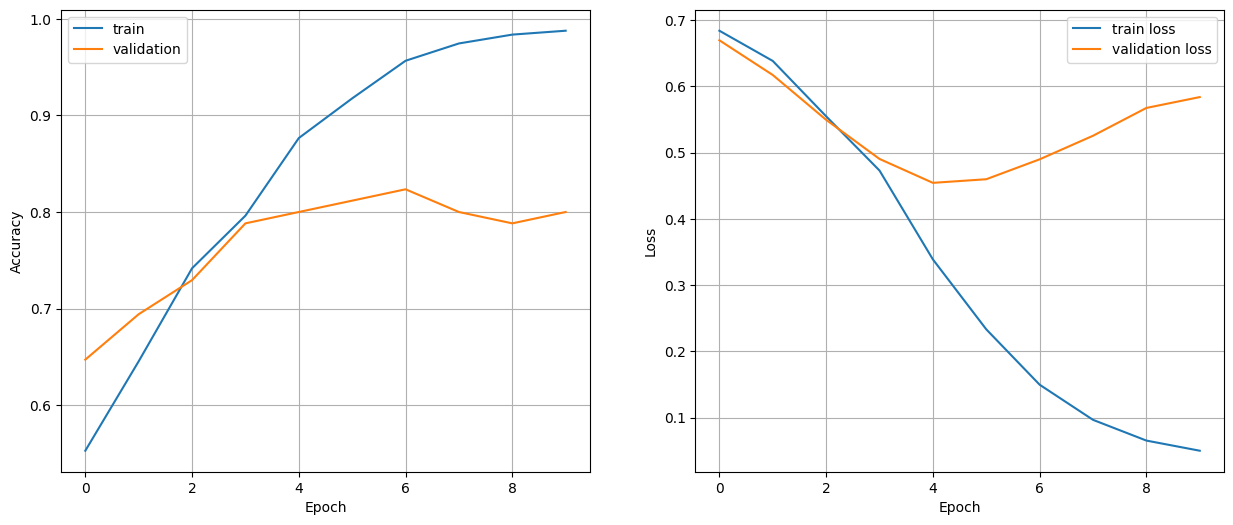

In [ ]:
plot(train_loss,validation_loss,train_acc,val_acc)

In [48]:
def Evaluate(model,test_loader):
  y_pred= []
  y_label=[]
  with torch.no_grad():
    for jdx, (sentence, label) in enumerate(iter(test_loader)):
      sentence, label = sentence.to(device),torch.tensor(list(label)).to(device)
      # Feed forward
      outputs = model(sentence)
      pred = torch.argmax(outputs, dim=1)
      for i in range(len(label)):
        y_pred.append(pred[i].item())
        y_label.append(label[i].item())
  print(classification_report(y_label, y_pred))
  print(f'''Accuracy: {round(accuracy_score(y_label, y_pred, normalize=True),6)}
  \nPrecision:{round(precision_score(y_label, y_pred, average='macro'),6)}
  \nRecall: {round(recall_score(y_label, y_pred, average='macro'),6)}
  \nF1 score: {round(f1_score(y_label, y_pred, average='macro'),6)}''')

In [49]:
Evaluate(model,test_loader)

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1156
           1       0.75      0.73      0.74      1227

    accuracy                           0.73      2383
   macro avg       0.73      0.73      0.73      2383
weighted avg       0.74      0.73      0.73      2383

Accuracy: 0.734788
  
Precision:0.734724
  
Recall: 0.734928
  
F1 score: 0.73471


# General_comment

In [50]:
class_weights_related

{0: 1.4844587352625938, 1: 0.7064524356031625, 2: 1.0978993261989696}

In [51]:
embed_size_ = embedding_matrixs_related.shape[1]
vocab_size_ = embedding_matrixs_related.shape[0]
num_classes_ = 3
num_filters=36

model_General_comment = CNN_Model_TEXT(vocab_size_, embed_size_, embedding_matrixs_related,num_classes_,num_filters)

model_General_comment.to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_related.values())).float().to(device))
optimizer = optim.Adam(model_General_comment.parameters(), lr=0.0001, weight_decay=0.005)

In [52]:
train_loss,validation_loss,train_acc,val_acc=training_loop(25,model_General_comment,data_loader_Relatedset,data_loader_Valrelated,criterion,optimizer)

epoch: 1 -  train loss: 1.0990063927390359 - validation loss: 1.0966688394546509 - train acc = 0.23561524762550884 - validation acc = 0.24705882352941178
epoch: 2 -  train loss: 1.094402248209173 - validation loss: 1.0960386991500854 - train acc = 0.2789428214043419 - validation acc = 0.2823529411764706
epoch: 3 -  train loss: 1.0920469869266858 - validation loss: 1.0954488515853882 - train acc = 0.3231311482360923 - validation acc = 0.3411764705882353
epoch: 4 -  train loss: 1.0904136029156772 - validation loss: 1.0950366258621216 - train acc = 0.3621401161804613 - validation acc = 0.43529411764705883
epoch: 5 -  train loss: 1.08802668614821 - validation loss: 1.0946193933486938 - train acc = 0.40595318860244234 - validation acc = 0.4235294117647059
epoch: 6 -  train loss: 1.0871787938204678 - validation loss: 1.0946801900863647 - train acc = 0.4343893105495251 - validation acc = 0.4235294117647059
epoch: 7 -  train loss: 1.0858971747485073 - validation loss: 1.094414472579956 - train

In [53]:
Evaluate(model_General_comment,test_loader_Related)

              precision    recall  f1-score   support

           0       0.29      0.33      0.31       269
           1       0.53      0.69      0.60       575
           2       0.40      0.18      0.25       381

    accuracy                           0.45      1225
   macro avg       0.41      0.40      0.38      1225
weighted avg       0.44      0.45      0.43      1225

Accuracy: 0.451429
  
Precision:0.405874
  
Recall: 0.398683
  
F1 score: 0.384203


## InRelationship

In [54]:
embed_size_ = embedding_matrixs_related.shape[1]
vocab_size_ = embedding_matrixs_related.shape[0]
num_classes_ = 3
num_filters=36

model_InRelationship = CNN_Model_TEXT(vocab_size_, embed_size_, embedding_matrixs_related,num_classes_,num_filters)

model_InRelationship.to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_InRelationship_related.values())).float().to(device))
optimizer = optim.Adam(model_InRelationship.parameters(), lr=0.001, weight_decay=0.00005)

In [55]:
train_loss,validation_loss,train_acc,val_acc=training_loop(20,model_InRelationship,data_loader_InRelationship_Relatedset,data_loader_InRelationship_Valrelated,criterion,optimizer)

epoch: 1 -  train loss: 1.0920855023644187 - validation loss: 1.0782760381698608 - train acc = 0.3916018275101764 - validation acc = 0.6470588235294118
epoch: 2 -  train loss: 1.0599451390179722 - validation loss: 1.0598160028457642 - train acc = 0.5444278960312077 - validation acc = 0.5411764705882353
epoch: 3 -  train loss: 1.0234812172976406 - validation loss: 1.0255147218704224 - train acc = 0.6791839806648575 - validation acc = 0.6352941176470588
epoch: 4 -  train loss: 0.9740511775016785 - validation loss: 0.983102023601532 - train acc = 0.6917936948778833 - validation acc = 0.5882352941176471
epoch: 5 -  train loss: 0.8984736691821705 - validation loss: 0.9137494564056396 - train acc = 0.7393624915196745 - validation acc = 0.7058823529411765
epoch: 6 -  train loss: 0.8043193979696794 - validation loss: 0.8469043970108032 - train acc = 0.7865189323270013 - validation acc = 0.7294117647058823
epoch: 7 -  train loss: 0.6991830197247592 - validation loss: 0.783989429473877 - train a

In [56]:
Evaluate(model_InRelationship,test_loader_InRelationship_Related)

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       650
           1       0.35      0.16      0.22        51
           2       0.73      0.82      0.77       524

    accuracy                           0.77      1225
   macro avg       0.64      0.59      0.60      1225
weighted avg       0.77      0.77      0.77      1225

Accuracy: 0.773061
  
Precision:0.636193
  
Recall: 0.587097
  
F1 score: 0.598409


# Specific_comment


In [57]:
class_weights_specific

{0: 1.0259305729820158, 1: 1.0233625365039634, 2: 0.9541034616880592}

In [58]:
embed_size__ = embedding_matrixs_specific.shape[1]
vocab_size__ = embedding_matrixs_specific.shape[0]
num_classes__ = 3
num_filters=36

model_Specific_comment = CNN_Model_TEXT(vocab_size__, embed_size__, embedding_matrixs_specific,num_classes__,num_filters)

model_Specific_comment.to(device)


criterion = nn.CrossEntropyLoss(ignore_index=0,weight=torch.tensor(list(class_weights_specific.values())).float().to(device)) # weighted negative log likelihood loss
optimizer = optim.Adam(model_Specific_comment.parameters(),lr=0.001, weight_decay=0.00005)

In [59]:
train_loss_,validation_loss_,train_acc_,val_acc_=training_loop(50,model_Specific_comment,data_loader_Specific_set,data_loader_Valspecific,criterion,optimizer)


epoch: 1 -  train loss: 1.0015202283859252 - validation loss: 0.8992960453033447 - train acc = 0.34734375 - validation acc = 0.3411764705882353
epoch: 2 -  train loss: 0.8119017362594605 - validation loss: 0.7804434299468994 - train acc = 0.35164062500000004 - validation acc = 0.3411764705882353
epoch: 3 -  train loss: 0.709375512599945 - validation loss: 0.7284325957298279 - train acc = 0.408515625 - validation acc = 0.3058823529411765
epoch: 4 -  train loss: 0.6748887419700622 - validation loss: 0.7175107598304749 - train acc = 0.40765624999999994 - validation acc = 0.32941176470588235
epoch: 5 -  train loss: 0.6543228149414062 - validation loss: 0.7202281951904297 - train acc = 0.451953125 - validation acc = 0.3058823529411765
epoch: 6 -  train loss: 0.6380778431892395 - validation loss: 0.7151602506637573 - train acc = 0.473125 - validation acc = 0.32941176470588235
epoch: 7 -  train loss: 0.6184780836105347 - validation loss: 0.7159066796302795 - train acc = 0.48851562499999995 - 

In [60]:
Evaluate(model_Specific_comment,test_loader_Specific)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       171
           1       0.42      0.56      0.48       181
           2       0.44      0.69      0.54       195

    accuracy                           0.43       547
   macro avg       0.29      0.42      0.34       547
weighted avg       0.29      0.43      0.35       547

Accuracy: 0.429616
  
Precision:0.285476
  
Recall: 0.415064
  
F1 score: 0.33783


--------------------------

# Bilstm

# Architecture

In [61]:
class BiLSTM(nn.Module):

    def __init__(self,max_features, embed_size, embedding_matrix, num_classes, hidden_size):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        drp = 0.5
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))

        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        #print("avg_pool", avg_pool.size())
        #print("max_pool", max_pool.size())
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        out = self.softmax(out)
        return out

In [62]:
def training_loop_(e, model,data_loader,valid_loader,criterion,optimizer):
# number of epochs to train the model
    import time
    start_time = time.time()
    n_epochs = e
   # test_loss_min = np.Inf # track change in validation loss
    train_acc=[]
    val_acc = []
    for epoch in range(n_epochs):

        # keep track of training and validation loss
        train_loss = 0.0
        test_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        running_acc=0
        for i, (data, target) in enumerate(data_loader):
            # move tensors to GPU if CUDA is available
            target = torch.tensor([[t] for t in target])
            data, target = data.to(device),torch.tensor(list(target)).to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            y_pred = torch.round(torch.sigmoid(output))
            output =  torch.argmax(output, dim=1).float()

            running_acc += torch.round((((output == target).sum().float() /len(target))) * 100)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()

        ######################
        # validate the model #
        ######################
        model.eval()
        running_acc_valid = 0.0
        for j,(data, target) in enumerate(valid_loader):
            # target = target.unsqueeze(1)
            target = torch.tensor([[t] for t in target])
            data, target = data.to(device),torch.tensor(list(target)).to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            output =  torch.argmax(output, dim=1).float()
            # y_pred_tag = torch.round(torch.sigmoid(output))
            running_acc_valid += torch.round((((output == target).sum().float() /len(target))) * 100)
            # update average validation loss
            test_loss += loss.item()

        # calculate average losses
        print(f'epoch: {epoch+1} -  train loss: {train_loss / (i+1)} - validation loss: {test_loss/(j+1)} - train acc = {running_acc/(i+1)} - validation acc = {running_acc_valid/(j+1)}')

        train_loss = train_loss/len(data_loader)
        test_loss = test_loss/len(valid_loader)
        train_acc.append(running_acc/(i+1))
        val_acc.append(running_acc_valid/(j+1))
        torch.save(model.cpu().state_dict(), 'final_model.pth')
        model.to(device)
    running_time = time.time()-start_time
    print(f'training Finished in {running_time} seconds')
    return train_loss,test_loss,train_acc,val_acc

## Relevance_Bilstm

In [63]:
embed_size = embedding_matrixs.shape[1]
vocab_size = embedding_matrixs.shape[0]
num_classes = 2

model_Relevance_Bilstm = BiLSTM(vocab_size, embed_size, embedding_matrixs,num_classes,20)
model_Relevance_Bilstm.to(device)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model_Relevance_Bilstm.parameters(), lr=0.001, weight_decay=0.0005)

In [64]:
train_loss,validation_loss,train_acc,val_acc=training_loop_(10,model_Relevance_Bilstm,data_loader_Trianset,data_loader_Val,criterion,optimizer)

epoch: 1 -  train loss: 0.692989240993153 - validation loss: 0.692179262638092 - train acc = 51.72727584838867 - validation acc = 54.0
epoch: 2 -  train loss: 0.6935492672703483 - validation loss: 0.6906390190124512 - train acc = 50.5 - validation acc = 54.0
epoch: 3 -  train loss: 0.6922976239161058 - validation loss: 0.6905774474143982 - train acc = 51.1363639831543 - validation acc = 54.0
epoch: 4 -  train loss: 0.691797985271974 - validation loss: 0.6883116960525513 - train acc = 52.36363983154297 - validation acc = 54.0
epoch: 5 -  train loss: 0.6902504021471197 - validation loss: 0.6866044402122498 - train acc = 52.590911865234375 - validation acc = 60.0
epoch: 6 -  train loss: 0.6845888116142966 - validation loss: 0.6752890348434448 - train acc = 56.681819915771484 - validation acc = 62.0
epoch: 7 -  train loss: 0.6677752462300387 - validation loss: 0.6381511092185974 - train acc = 61.81818389892578 - validation acc = 65.0
epoch: 8 -  train loss: 0.6326286115429618 - validation 

In [65]:
Evaluate(model_Relevance_Bilstm,test_loader)

              precision    recall  f1-score   support

           0       0.69      0.74      0.71      1156
           1       0.73      0.69      0.71      1227

    accuracy                           0.71      2383
   macro avg       0.71      0.71      0.71      2383
weighted avg       0.71      0.71      0.71      2383

Accuracy: 0.711288
  
Precision:0.712141
  
Recall: 0.712033
  
F1 score: 0.711284


## General_comment_Bilstm

In [66]:
embed_size_ = embedding_matrixs_related.shape[1]
vocab_size_ = embedding_matrixs_related.shape[0]
num_classes_ = 3

model_General_comment_Bilstm = BiLSTM(vocab_size_, embed_size_, embedding_matrixs_related,num_classes_,10)


model_General_comment_Bilstm.to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_related.values())).float().to(device))

# specify optimizer
optimizer = optim.Adam(model_General_comment_Bilstm.parameters(), lr=0.0001, weight_decay=0.000005)

In [67]:
train_loss,validation_loss,train_acc,val_acc=training_loop_(80,model_General_comment_Bilstm,data_loader_Relatedset,data_loader_Valrelated,criterion,optimizer)

epoch: 1 -  train loss: 1.1017352884465998 - validation loss: 1.1048487424850464 - train acc = 40.181819915771484 - validation acc = 44.0
epoch: 2 -  train loss: 1.102652289650657 - validation loss: 1.1036230325698853 - train acc = 38.0 - validation acc = 42.0
epoch: 3 -  train loss: 1.1002997918562456 - validation loss: 1.1027157306671143 - train acc = 38.0 - validation acc = 40.0
epoch: 4 -  train loss: 1.098748044534163 - validation loss: 1.1019070148468018 - train acc = 37.3636360168457 - validation acc = 41.0
epoch: 5 -  train loss: 1.097134525125677 - validation loss: 1.1013667583465576 - train acc = 38.181819915771484 - validation acc = 41.0
epoch: 6 -  train loss: 1.0971573157743975 - validation loss: 1.1008861064910889 - train acc = 38.3636360168457 - validation acc = 41.0
epoch: 7 -  train loss: 1.0961969332261519 - validation loss: 1.1004972457885742 - train acc = 39.181819915771484 - validation acc = 42.0
epoch: 8 -  train loss: 1.0964945879849521 - validation loss: 1.10015

In [68]:
Evaluate(model_General_comment_Bilstm,test_loader_Related)

              precision    recall  f1-score   support

           0       0.43      0.32      0.37       269
           1       0.62      0.72      0.67       575
           2       0.41      0.38      0.39       381

    accuracy                           0.53      1225
   macro avg       0.49      0.47      0.48      1225
weighted avg       0.51      0.53      0.52      1225

Accuracy: 0.527347
  
Precision:0.485688
  
Recall: 0.474371
  
F1 score: 0.476072


## InRelationship_Bilstm

In [69]:
embed_size_ = embedding_matrixs_related.shape[1]
vocab_size_ = embedding_matrixs_related.shape[0]
num_classes_ = 3

model_InRelationship_Bilstm = BiLSTM(vocab_size_, embed_size_, embedding_matrixs_related,num_classes_,10)


model_InRelationship_Bilstm.to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_InRelationship_related.values())).float().to(device))

# specify optimizer
optimizer = optim.Adam(model_InRelationship_Bilstm.parameters(),lr=0.0001, weight_decay=0.000005)

In [70]:
train_loss,validation_loss,train_acc,val_acc=training_loop_(70,model_InRelationship_Bilstm,data_loader_InRelationship_Relatedset,data_loader_InRelationship_Valrelated,criterion,optimizer)

epoch: 1 -  train loss: 1.1061491749503396 - validation loss: 1.1256499290466309 - train acc = 42.272727966308594 - validation acc = 31.0
epoch: 2 -  train loss: 1.1038097143173218 - validation loss: 1.122794270515442 - train acc = 42.090911865234375 - validation acc = 31.0
epoch: 3 -  train loss: 1.1022113778374412 - validation loss: 1.1198519468307495 - train acc = 42.272727966308594 - validation acc = 31.0
epoch: 4 -  train loss: 1.1032783009789207 - validation loss: 1.1171751022338867 - train acc = 42.272727966308594 - validation acc = 31.0
epoch: 5 -  train loss: 1.100009874864058 - validation loss: 1.1146881580352783 - train acc = 42.272727966308594 - validation acc = 31.0
epoch: 6 -  train loss: 1.100547432899475 - validation loss: 1.112742304801941 - train acc = 41.90909194946289 - validation acc = 31.0
epoch: 7 -  train loss: 1.0985050309788098 - validation loss: 1.1107088327407837 - train acc = 42.272727966308594 - validation acc = 31.0
epoch: 8 -  train loss: 1.0965075276114

In [71]:
Evaluate(model_InRelationship_Bilstm,test_loader_InRelationship_Related)

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       650
           1       0.08      0.10      0.09        51
           2       0.77      0.69      0.73       524

    accuracy                           0.73      1225
   macro avg       0.54      0.54      0.54      1225
weighted avg       0.74      0.73      0.74      1225

Accuracy: 0.733061
  
Precision:0.539284
  
Recall: 0.535144
  
F1 score: 0.535785


## Specific_comment_Bilstm

In [80]:
embed_size__ = embedding_matrixs_specific.shape[1]
vocab_size__ = embedding_matrixs_specific.shape[0]
num_classes__ = 3


model_Specific_comment_Bilstm  = BiLSTM(vocab_size__, embed_size__, embedding_matrixs_specific,num_classes__,10)


model_Specific_comment_Bilstm.to(device)


criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_specific.values())).float().to(device))
optimizer = optim.Adam(model_Specific_comment_Bilstm.parameters(), lr=0.0001, weight_decay=0.000005)

In [81]:
train_loss_,validation_loss_,train_acc_,val_acc_=training_loop(150,model_Specific_comment_Bilstm,data_loader_Specific_set,data_loader_Valspecific,criterion,optimizer)


epoch: 1 -  train loss: 1.10563063621521 - validation loss: 1.0978114604949951 - train acc = 0.32625000000000004 - validation acc = 0.35294117647058826
epoch: 2 -  train loss: 1.1035977125167846 - validation loss: 1.0977234840393066 - train acc = 0.32375 - validation acc = 0.35294117647058826
epoch: 3 -  train loss: 1.1031521558761597 - validation loss: 1.0976746082305908 - train acc = 0.32421875 - validation acc = 0.35294117647058826
epoch: 4 -  train loss: 1.1043853282928466 - validation loss: 1.0976344347000122 - train acc = 0.32039062500000004 - validation acc = 0.35294117647058826
epoch: 5 -  train loss: 1.1021503686904908 - validation loss: 1.0976194143295288 - train acc = 0.32406250000000003 - validation acc = 0.35294117647058826
epoch: 6 -  train loss: 1.1017203330993652 - validation loss: 1.0976122617721558 - train acc = 0.32515625 - validation acc = 0.35294117647058826
epoch: 7 -  train loss: 1.10047447681427 - validation loss: 1.0976284742355347 - train acc = 0.330546875 - v

In [82]:
Evaluate(model_Specific_comment_Bilstm,test_loader_Specific)

              precision    recall  f1-score   support

           0       0.46      0.55      0.50       171
           1       0.40      0.33      0.36       181
           2       0.42      0.42      0.42       195

    accuracy                           0.43       547
   macro avg       0.43      0.43      0.43       547
weighted avg       0.43      0.43      0.43       547

Accuracy: 0.429616
  
Precision:0.426886
  
Recall: 0.432062
  
F1 score: 0.426932
